Note: excluded:
- data_pKA = read_sdf(pKA_path, 'pKa')
- data_RBiodeg = read_sdf(RBiodeg_path, 'RBiodeg') binary
- data_CoMPARA = read_sdf(CoMPARA_path, 'CoMPARA'), mixed 
- data_CATMOS = read_sdf(CATMOS_path, 'CATMOS') mixed
- data_CERAPP = read_sdf(CERAPP_path, 'CERAPP') mixed


In [1]:
from utils_data import load_data,scale_props,get_graphs
from utils_plotting import plot_property_histograms
from sklearn.model_selection import train_test_split
from utils_model import train_and_validate_multi,get_preds_per_task,preds_and_ys_to_df
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import AttentiveFP
import torch
import pandas as pd

In [2]:
df_combined = load_data()
df_combined

Loading data from file


,SMILES,LogVP,LogP,LogOH,LogBCF,LogHalfLife,BP,Clint,FU,LogHL,LogKmHL,LogKOA,LogKOC,MP,LogMolar
0,CC(O)C(=O)O,-1.089900,-0.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.8667,1.045401
1,Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1,-6.795899,6.91,NaN,4.29,NaN,NaN,0.866287,0.260000,-5.079877,1.93,9.82,5.31,108.5000,-7.723684
2,O=C(O)c1c(Cl)ccc(Cl)c1Cl,-3.259600,NaN,NaN,0.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.5000,-1.468200
3,c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34,-8.260400,6.13,NaN,NaN,2.3502,495.0,NaN,NaN,-6.340084,0.05,NaN,5.95,176.5000,-8.113298
4,COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C,-6.719001,2.30,NaN,NaN,NaN,NaN,NaN,0.106667,NaN,NaN,NaN,NaN,98.0000,-2.240472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23223,CN(CCO)c1ccc(N=Nc2c(Cl)cc([N+](=O)[O-])cc2Cl)cc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.369572
23224,CCC(O)CNCC(O)CC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.793092
23225,CC(C)(C)C(O)C(=CC1CCCCC1)n1cncn1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.409933
23226,CCC(N)P(=O)(O)O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000435


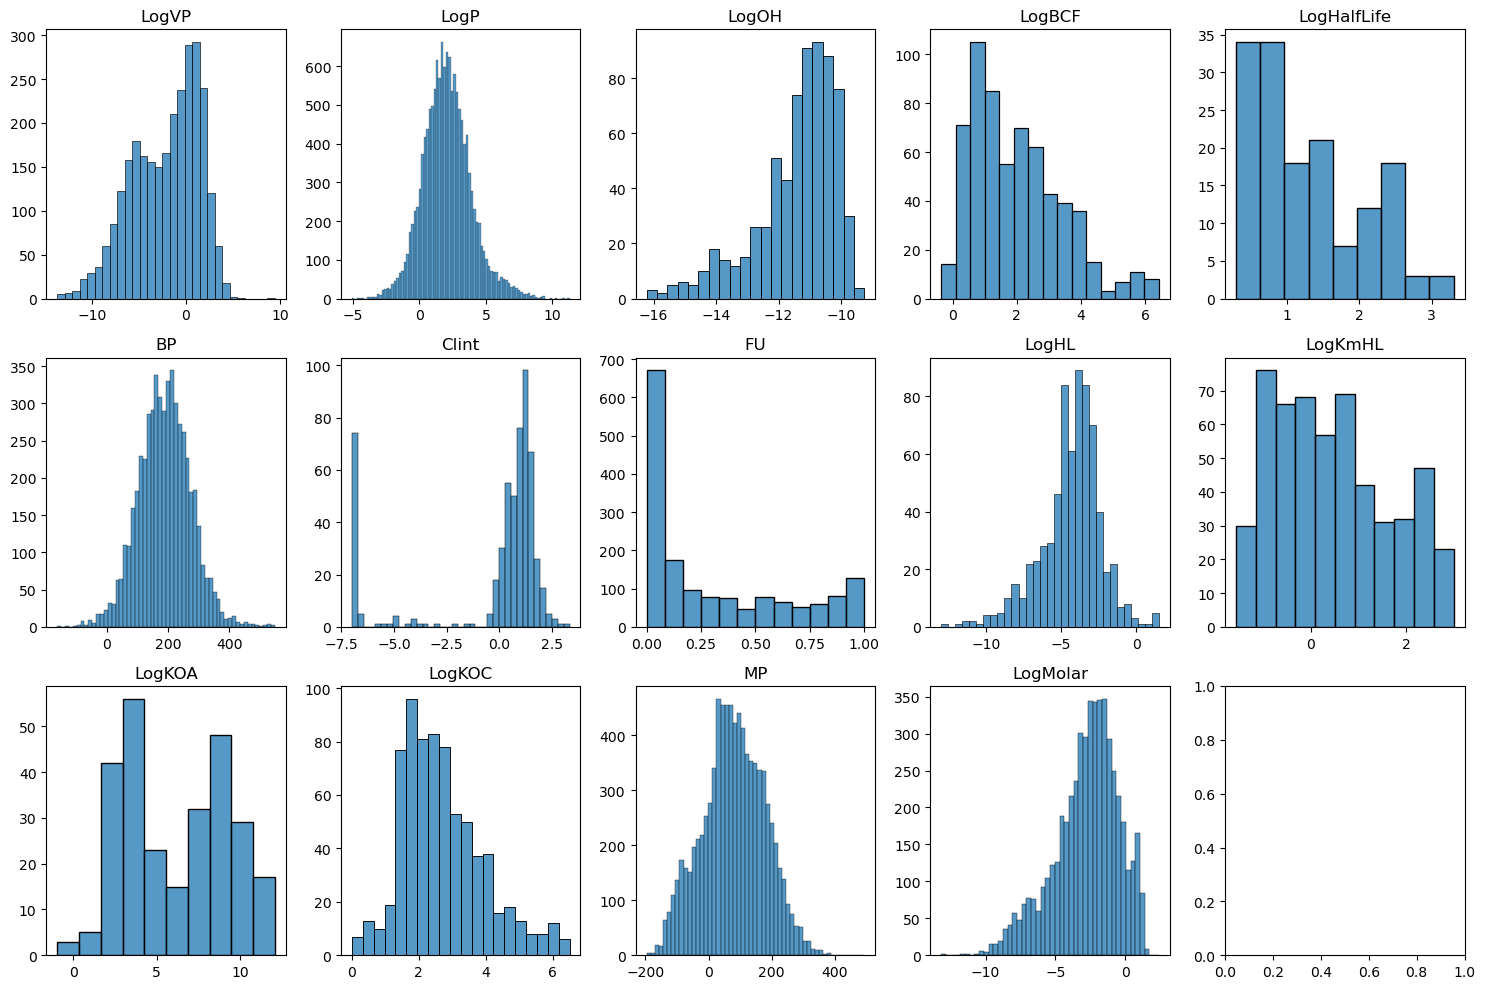

In [3]:
plot_property_histograms(df_combined)

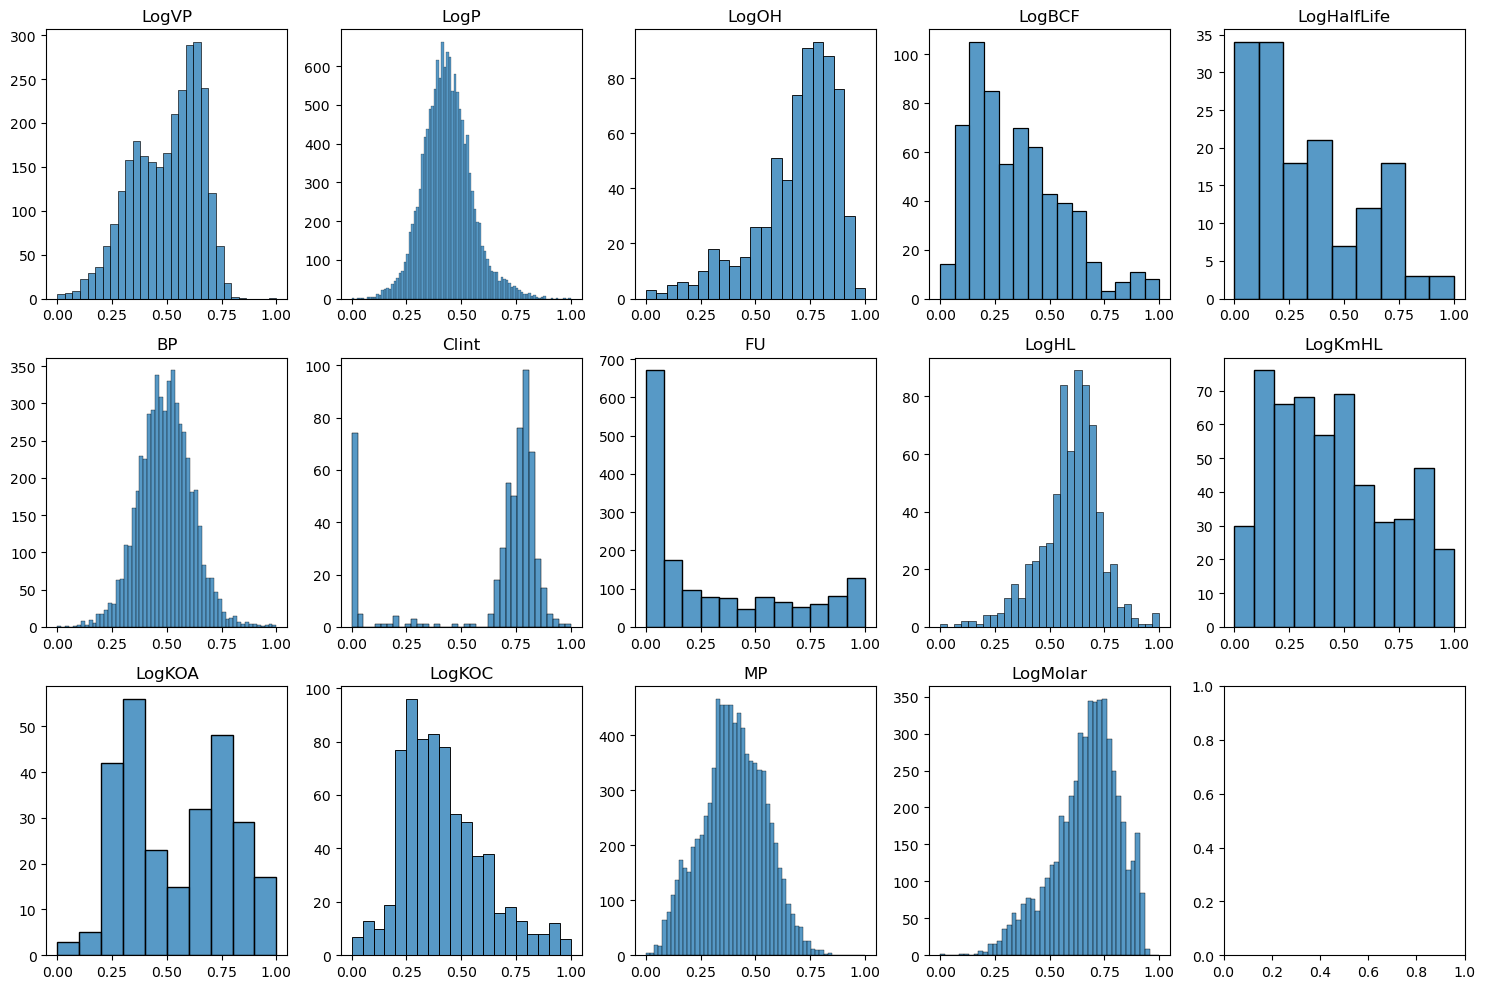

In [4]:
df_scaled,scaler = scale_props(df_combined)
plot_property_histograms(df_scaled)

In [5]:
#split check: if we do a random split 80/20, do we also get a 80/20 split for each property?
train, test = train_test_split(df_scaled, test_size=0.2, random_state=42)
for col in df_scaled.columns[1:]:
    print(f'{col}: {test[col].count()/df_scaled[col].count()}')

LogVP: 0.19005328596802842
LogP: 0.20147702014770202
LogOH: 0.17630057803468208
LogBCF: 0.1794871794871795
LogHalfLife: 0.19333333333333333
BP: 0.19860114117430516
Clint: 0.21245421245421245
FU: 0.18753894080996886
LogHL: 0.1750358680057389
LogKmHL: 0.17190388170055454
LogKOA: 0.18518518518518517
LogKOC: 0.19640387275242047
MP: 0.19798657718120805
LogMolar: 0.20590490797546013


In [6]:
graphs_no_charge_scaled = get_graphs(df_scaled,dash_charges=False,scaled =True,save_graphs = True)

Loading previously created graphs


In [7]:
graphs_DASH_charge_scaled = get_graphs(df_scaled,dash_charges=True,scaled =True,save_graphs = True)

Loading previously created graphs


In [8]:
outputs = 14
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data, test_data = train_test_split(graphs_DASH_charge_scaled, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=0)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
model= AttentiveFP(in_channels=24, hidden_channels=200, out_channels=outputs,
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3,
                        weight_decay=10**-4)
print(len(train_data), len(val_data), len(test_data))
train_and_validate_multi(model, train_loader, val_loader, optimizer, num_epochs=100, outputs=outputs, verbose=True)

14691 3673 4591
Epoch 1/100: Train Loss: 0.1456, Val Loss: 0.1074
Epoch 2/100: Train Loss: 0.1043, Val Loss: 0.1042


KeyboardInterrupt: 

In [9]:
preds, ys = get_preds_per_task(val_loader, outputs)

6680


In [10]:
#make df from preds
df_preds,df_ys = preds_and_ys_to_df(preds,ys,ref_df = df_combined,scaler = scaler)

Property: LogVP
kendall_tau: 0.773970562805388
rmse_overall: 1.512810284824537
mae_overall: 1.1056166878055866
within_03_overall: 0.1895734597156398
within_1_overall: 0.566350710900474
R2: 0.8285291829107403
Pearson: 0.9121173936558529


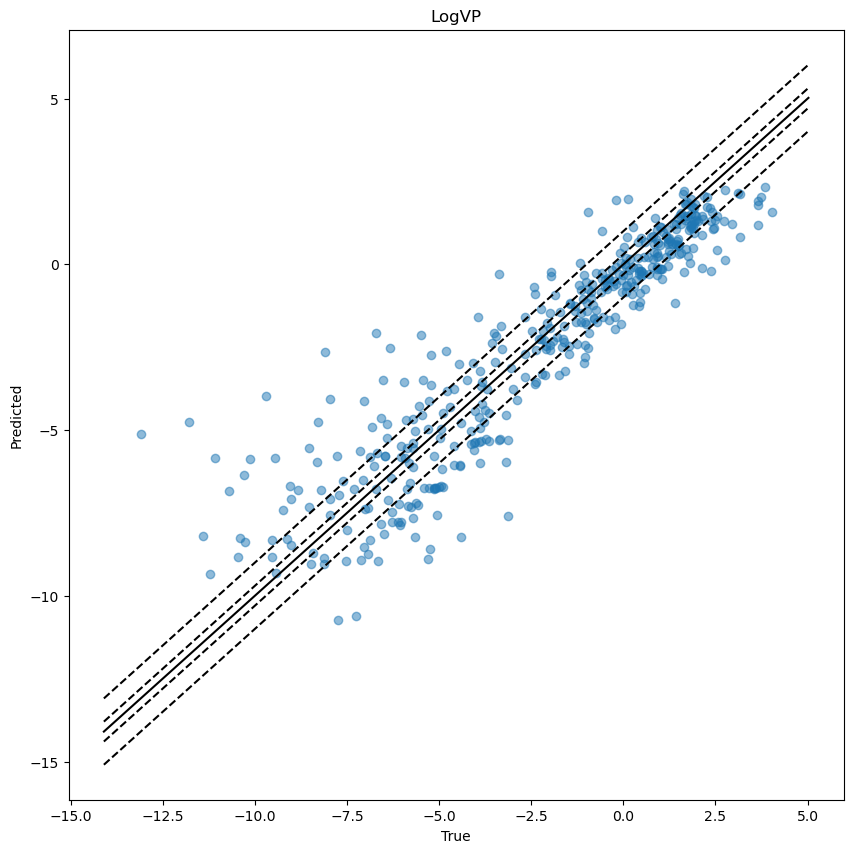

Property: LogP
kendall_tau: 0.6546668744020008
rmse_overall: 1.0618672197596875
mae_overall: 0.7847282197660943
within_03_overall: 0.2606741573033708
within_1_overall: 0.7321348314606742
R2: 0.6571547073322537
Pearson: 0.8505252190191567


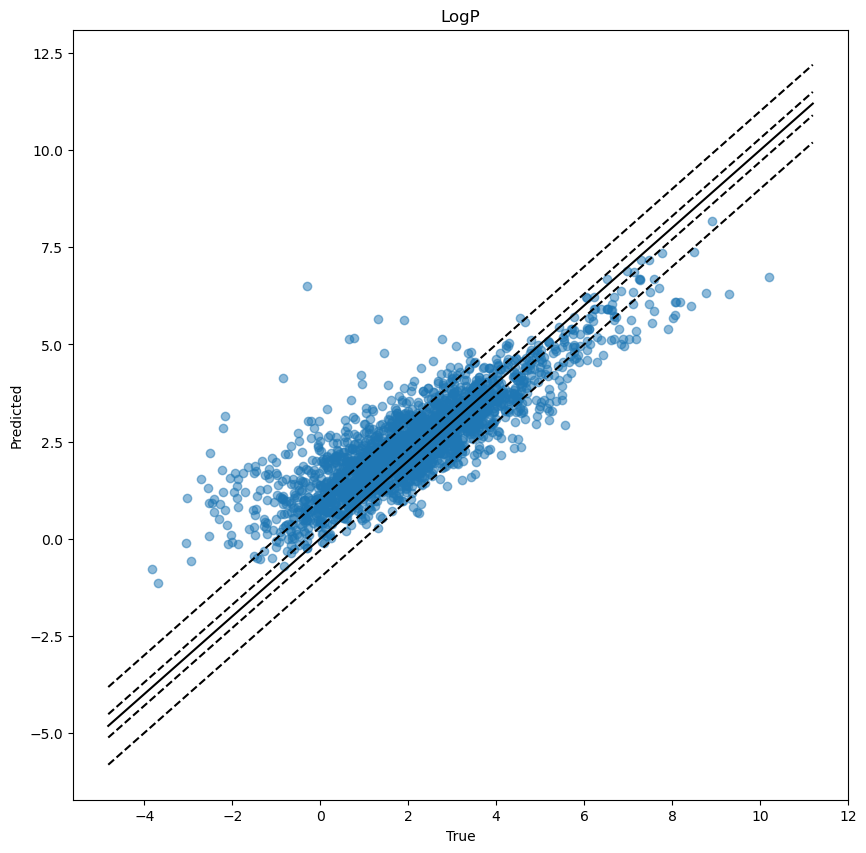

Property: LogOH
kendall_tau: 0.5027532400767831
rmse_overall: 0.8780506874092603
mae_overall: 0.707133469209162
within_03_overall: 0.2727272727272727
within_1_overall: 0.7
R2: 0.5091421187698892
Pearson: 0.730485018605948


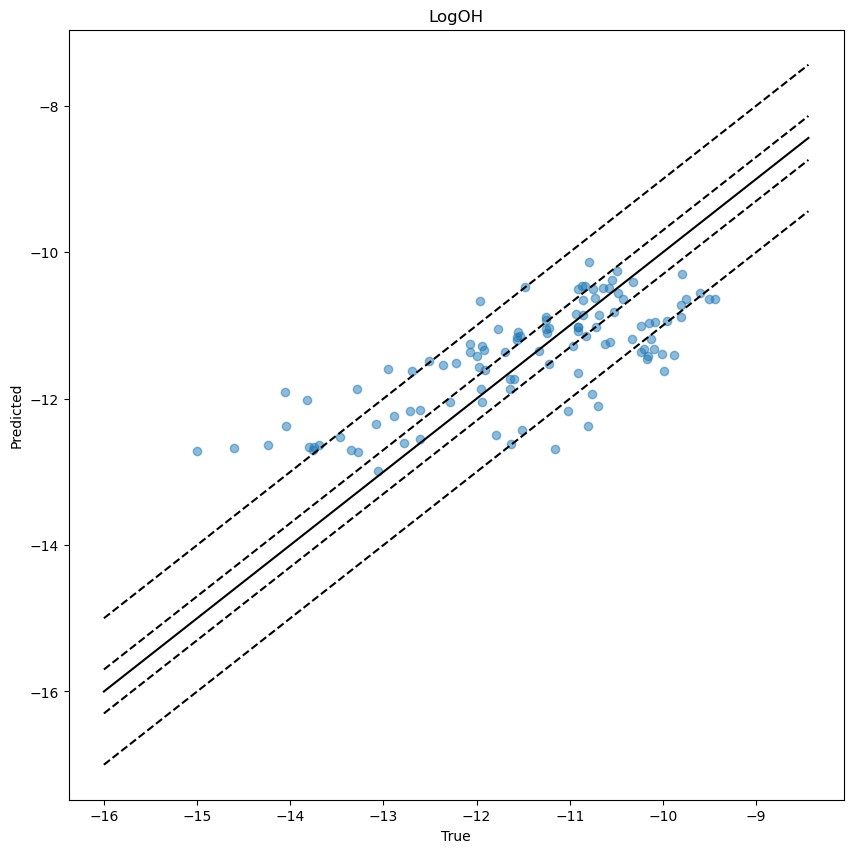

Property: LogBCF
kendall_tau: 0.6135739190964442
rmse_overall: 0.9262405779719255
mae_overall: 0.7269858729655303
within_03_overall: 0.27710843373493976
within_1_overall: 0.7710843373493976
R2: 0.570313969148336
Pearson: 0.7699583864392437


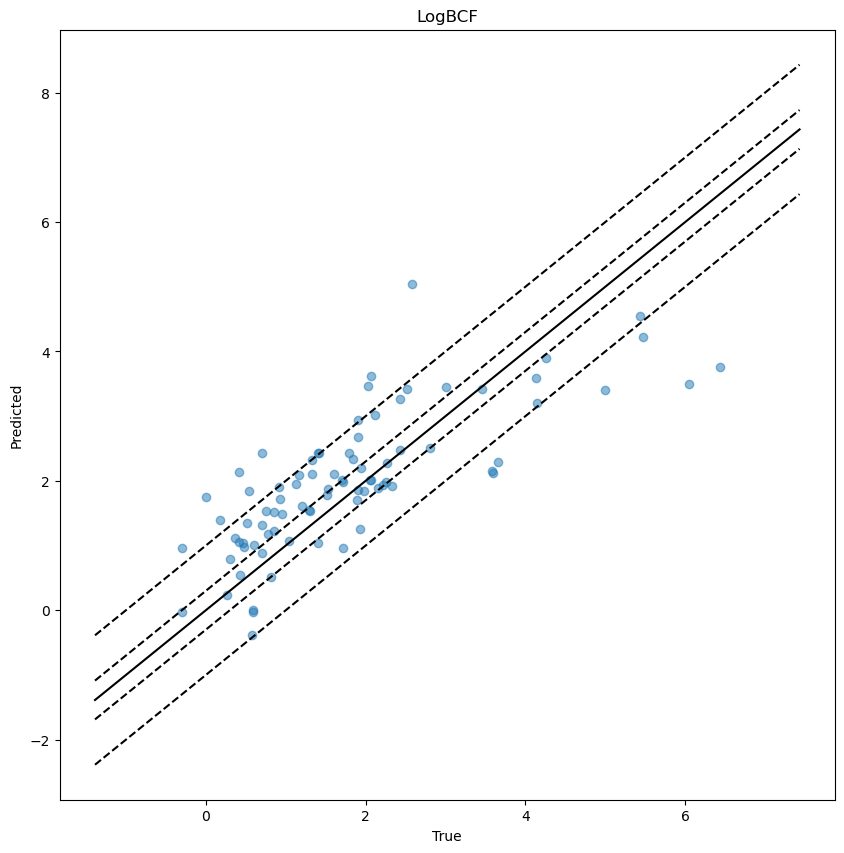

Property: LogHalfLife
kendall_tau: 0.3550501458394378
rmse_overall: 0.41922585621508635
mae_overall: 0.34587269514799124
within_03_overall: 0.52
within_1_overall: 1.0
R2: 0.6356334102907213
Pearson: 0.8395071429839589


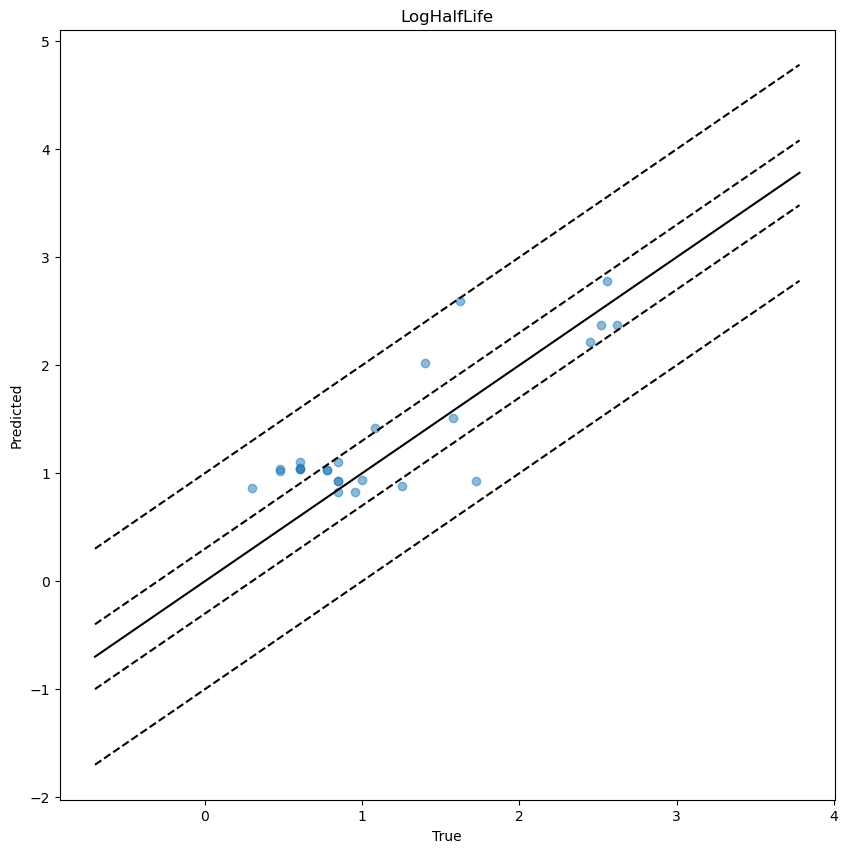

Property: BP
kendall_tau: 0.7137557899086532
rmse_overall: 38.67295652323469
mae_overall: 29.579718659837994
within_03_overall: 0.007255139056831923
within_1_overall: 0.02781136638452237
R2: 0.7728147855246987
Pearson: 0.8855117987392066


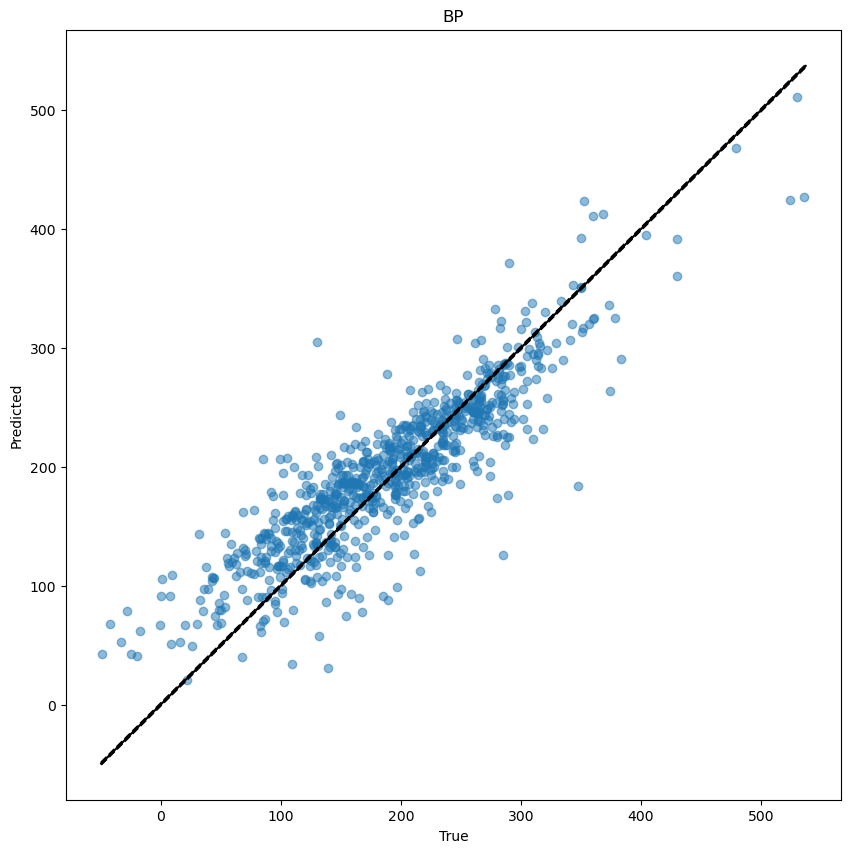

Property: Clint
kendall_tau: 0.08576514615852132
rmse_overall: 3.753464104187137
mae_overall: 2.4063671649414027
within_03_overall: 0.2
within_1_overall: 0.5375
R2: -0.23702511053845265
Pearson: 0.2376370417836583


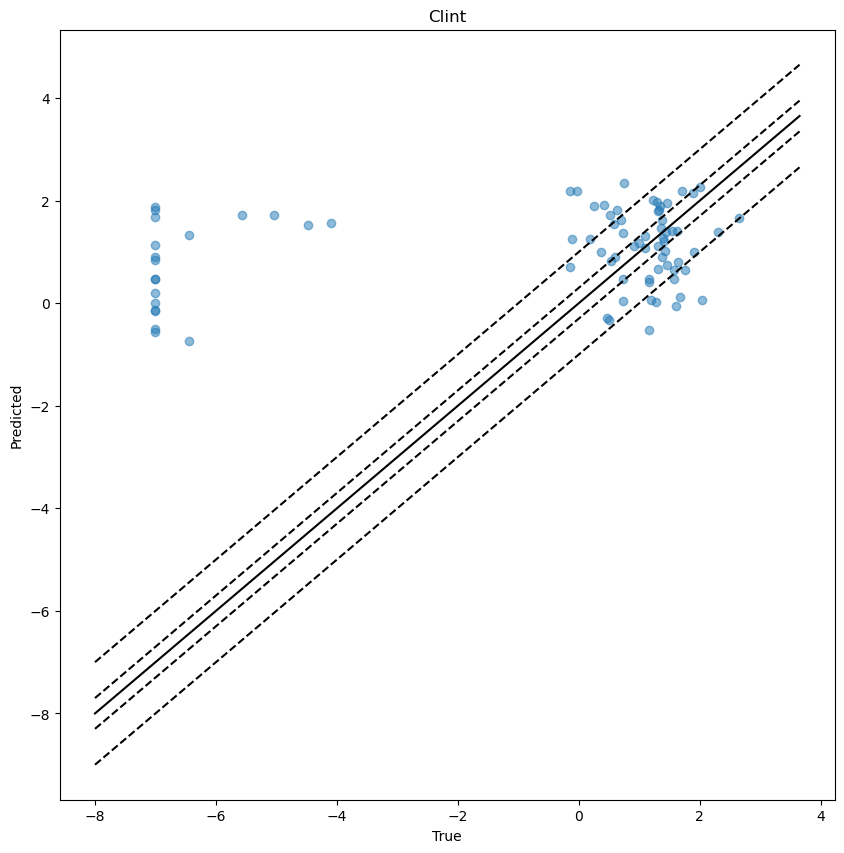

Property: FU
kendall_tau: 0.43897500987340415
rmse_overall: 0.28453823501155495
mae_overall: 0.24526727927458883
within_03_overall: 0.6704545454545454
within_1_overall: 1.0
R2: 0.2566330362579101
Pearson: 0.6033038089044445


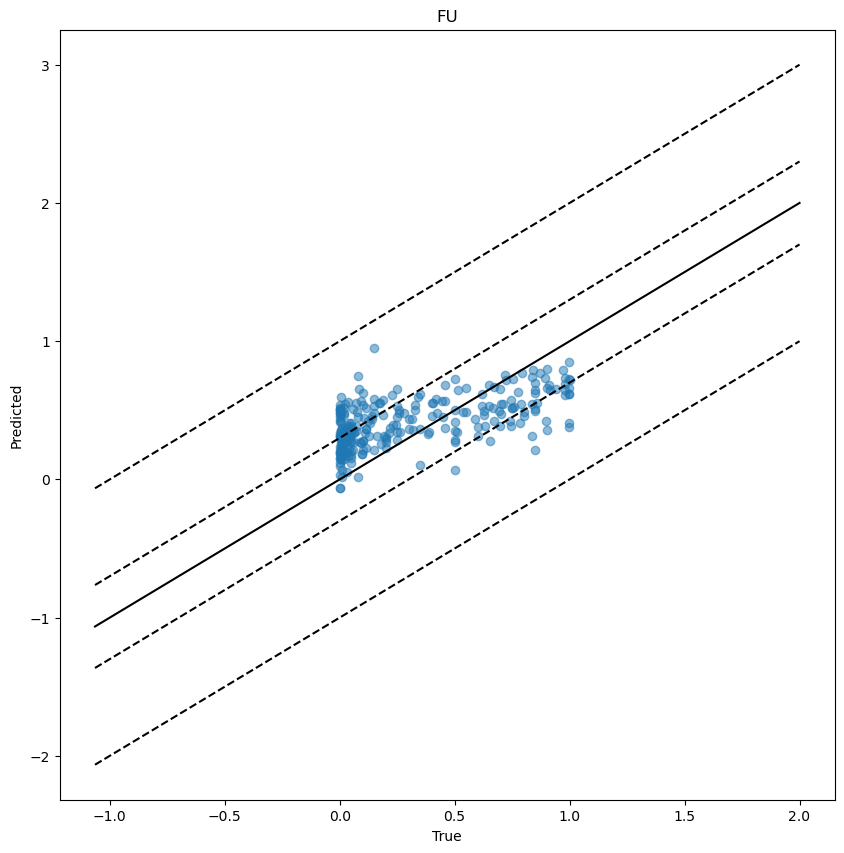

Property: LogHL
kendall_tau: 0.5320290357935471
rmse_overall: 1.3860189791493611
mae_overall: 1.0882048981810721
within_03_overall: 0.15254237288135594
within_1_overall: 0.559322033898305
R2: 0.47949647438008136
Pearson: 0.7580370287979009


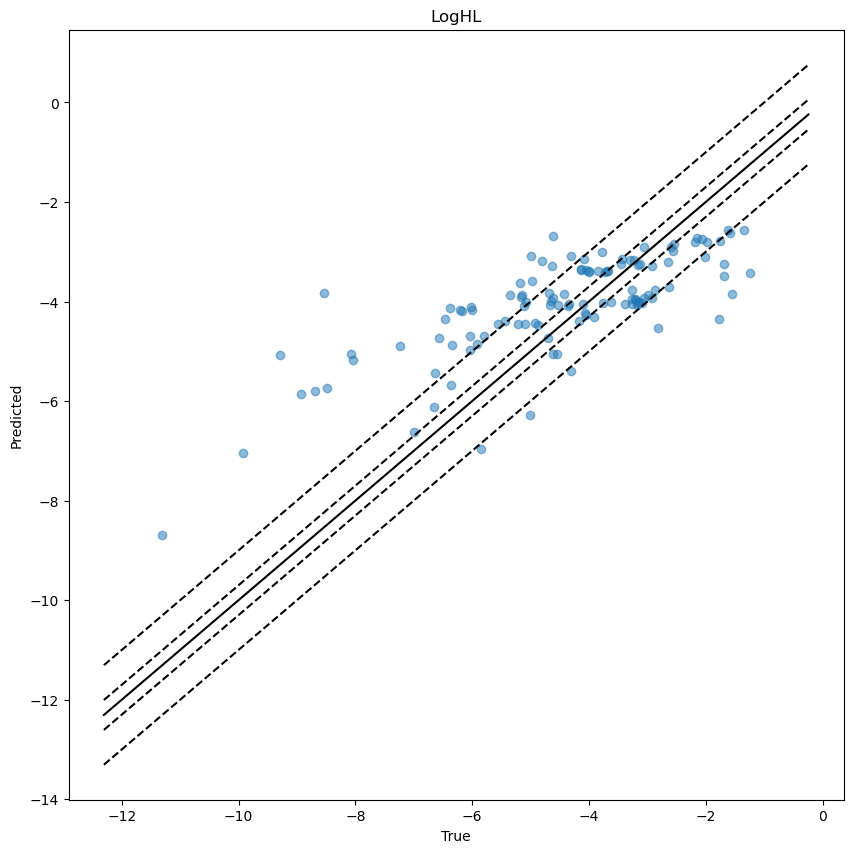

Property: LogKmHL
kendall_tau: 0.6322316087598199
rmse_overall: 0.7762224130711739
mae_overall: 0.6651426046893553
within_03_overall: 0.19753086419753085
within_1_overall: 0.7901234567901234
R2: 0.6361674499649113
Pearson: 0.8328854675916118


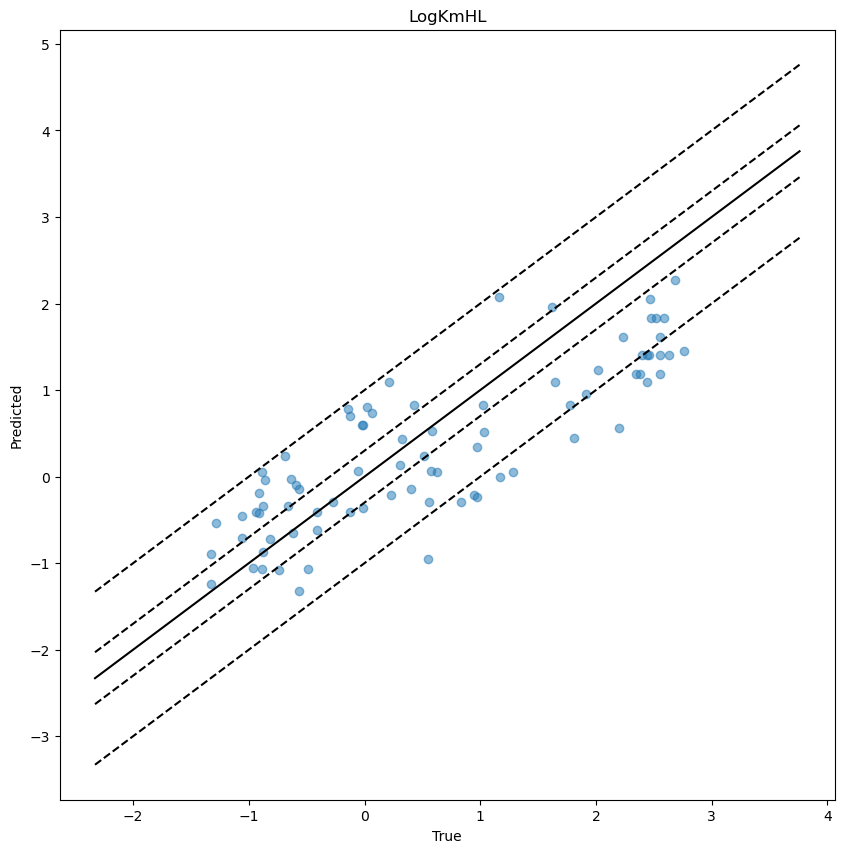

Property: LogKOA
kendall_tau: 0.7664311299068959
rmse_overall: 0.979432250708284
mae_overall: 0.7733153804043928
within_03_overall: 0.15555555555555556
within_1_overall: 0.7555555555555555
R2: 0.8946312279496841
Pearson: 0.9491607588213153


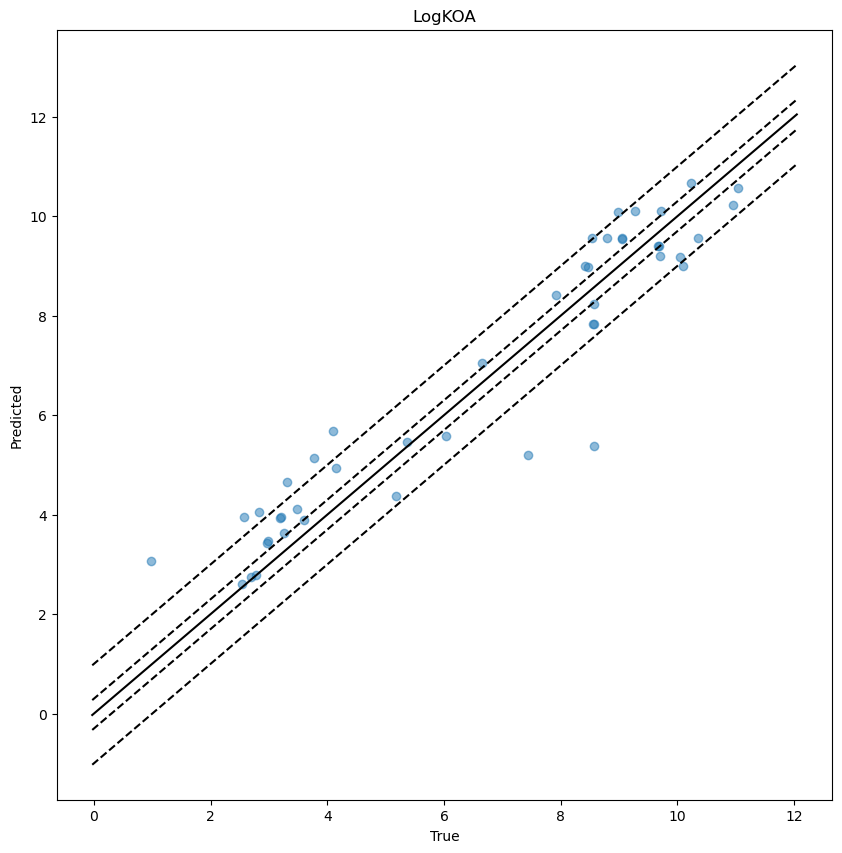

Property: LogKOC
kendall_tau: 0.6214428021565473
rmse_overall: 0.6498819014890485
mae_overall: 0.5195214191602694
within_03_overall: 0.34234234234234234
within_1_overall: 0.8738738738738738
R2: 0.7651157852456423
Pearson: 0.8878437249786636


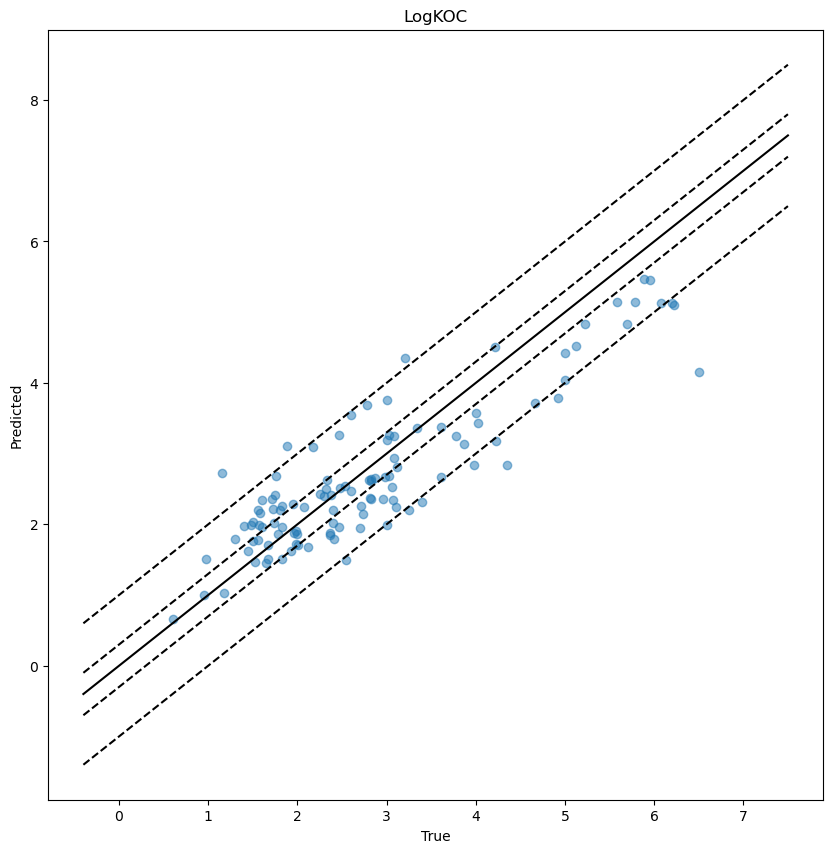

Property: MP
kendall_tau: 0.5836728527157531
rmse_overall: 64.62512924487038
mae_overall: 48.93428977984142
within_03_overall: 0.007779349363507779
within_1_overall: 0.014144271570014143
R2: 0.5810934532165062
Pearson: 0.7785670655816291


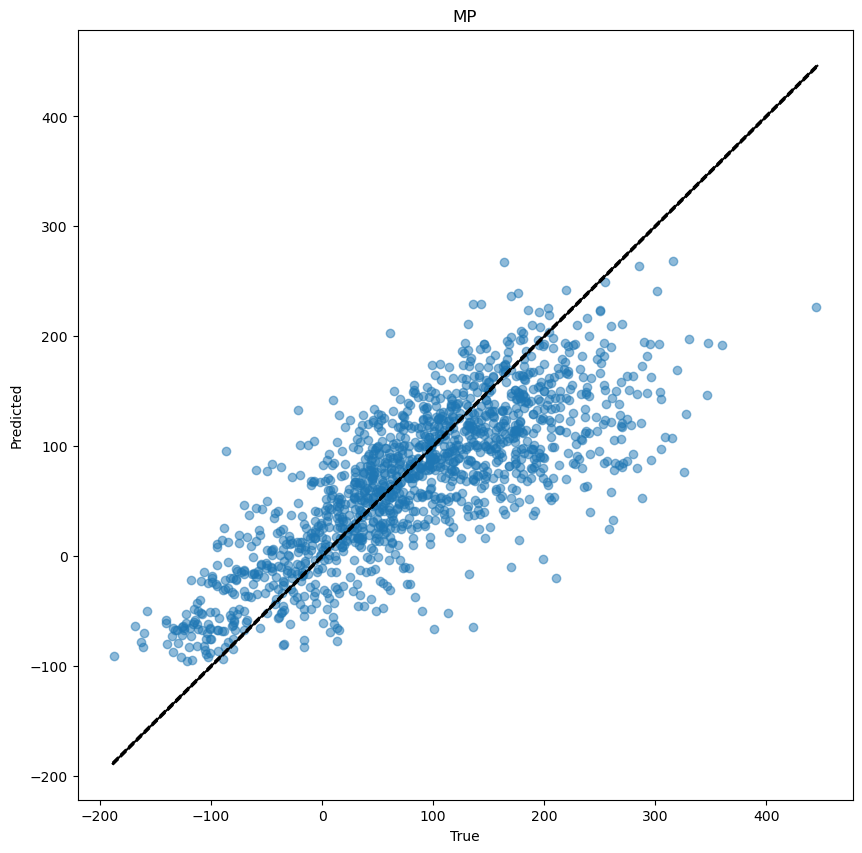

Property: LogMolar
kendall_tau: 0.648024165131115
rmse_overall: 1.315965210659255
mae_overall: 0.9848392080051942
within_03_overall: 0.224
within_1_overall: 0.6102857142857143
R2: 0.6904521281661609
Pearson: 0.8585989787243276


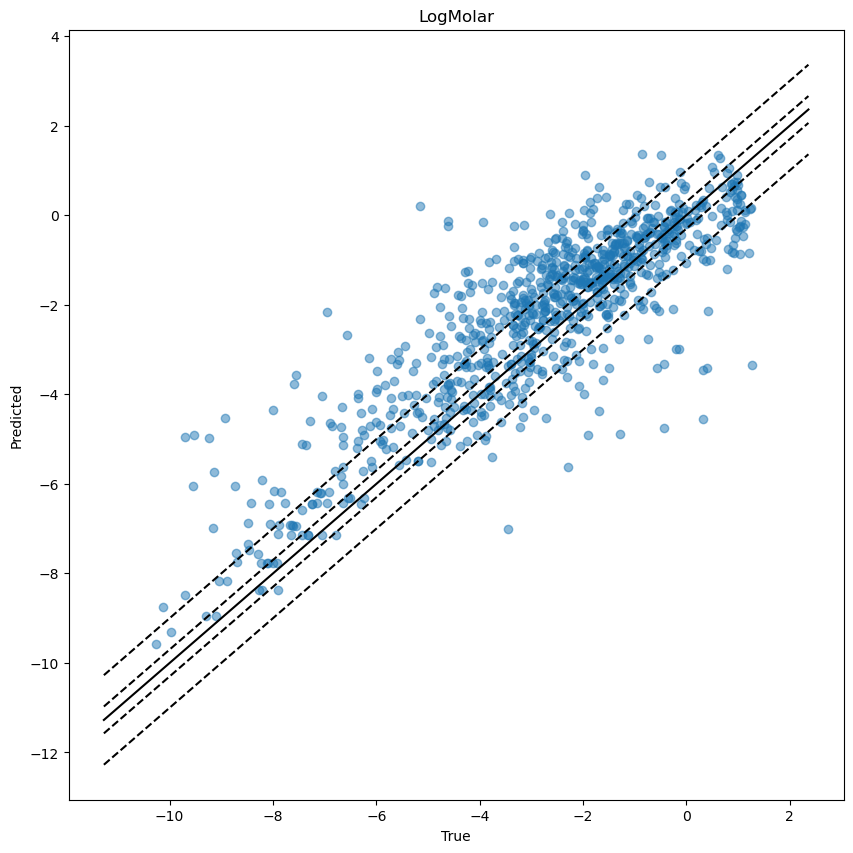

In [11]:
#plot
from utils_plotting import plot_scatters
plot_scatters(df_preds,df_ys)

To do:
1. Add the different endpoints - check
2. Normalization of values
3. Weighting of the tasks
4. Hyperparameter optimization
5. Benchmarking datasets? E.g. SAMPL7 for logP
6. Quadruple check refs - check
7. Think about datasplitting: same splits as OPERA? possible? otherwise, just cross-val? or random splits (multiple)
8. Different random weight initializations of the model


split: 80/20 5x

HP OPT: https://docs.ray.io/en/latest/tune/api/doc/ray.tune.search.bayesopt.BayesOptSearch.html
Repeated K-fold: https://greglandrum.github.io/rdkit-blog/posts/2023-08-13-xval-variability1.html